In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [9]:
df=pd.read_csv('airline_passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [11]:
df['Month']=pd.to_datetime(df['Month'])

In [12]:
df.set_index('Month',inplace=True)


In [13]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


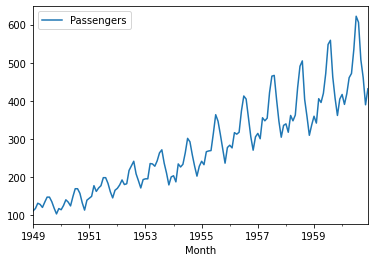

In [15]:
df.plot()

In [16]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Passengers):
    result=adfuller(Passengers)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [18]:
adfuller_test(df['Passengers'])

ADF Test Statistic : 0.8153688792060418
p-value : 0.9918802434376409
#Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [21]:
df['Passenger First Difference'] = df['Passengers'] - df['Passengers'].shift(1)

In [22]:
df['Passenger seasonal Difference'] = df['Passengers'] - df['Passengers'].shift(12)

In [23]:
df.head(15)

,Passengers,Passenger First Difference,Passenger seasonal Difference
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,NaN
1949-04-01,129,-3.0,NaN
1949-05-01,121,-8.0,NaN
1949-06-01,135,14.0,NaN
1949-07-01,148,13.0,NaN
1949-08-01,148,0.0,NaN
1949-09-01,136,-12.0,NaN


In [24]:
adfuller_test(df['Passenger seasonal Difference'].dropna())

ADF Test Statistic : -3.383020726492481
p-value : 0.011551493085514952
#Lags Used : 1
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


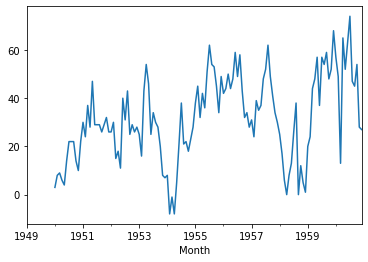

In [25]:
df['Passenger seasonal Difference'].plot()

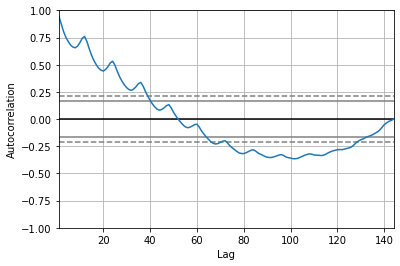

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Passengers'])
plt.show()

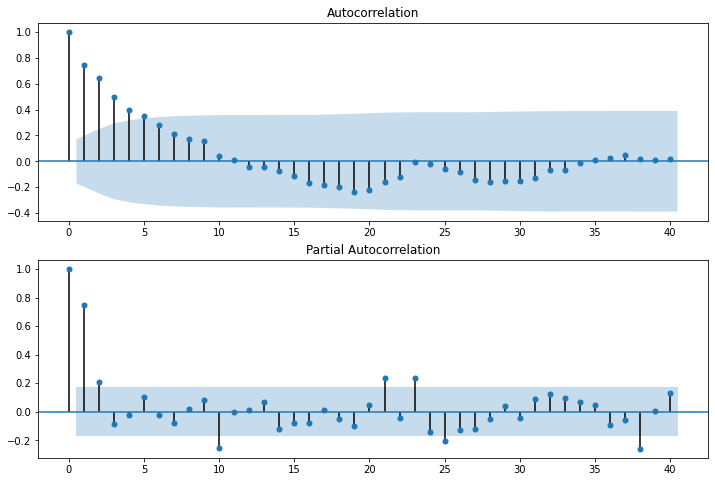

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Passenger seasonal Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Passenger seasonal Difference'].iloc[13:],lags=40,ax=ax2)

In [29]:
model_arima=ARIMA(df['Passengers'],order=(1,1,1))
model_arima_fit=model_arima.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [30]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -697.073
Method:                       css-mle   S.D. of innovations             31.338
Date:                Wed, 13 Jan 2021   AIC                           1402.145
Time:                        04:04:55   BIC                           1413.997
Sample:                    02-01-1949   HQIC                          1406.961
                         - 12-01-1960                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6112      0.228     11.435      0.000       2.164       3.059
ar.L1.D.Passengers     0.7400      0.058     12.778      0.000       0.626       0.854
ma.L1.D.Passengers    -1.0000      0.019    -53.425      0.000      -1.037      -0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3513           +0.0000j            1.3513            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

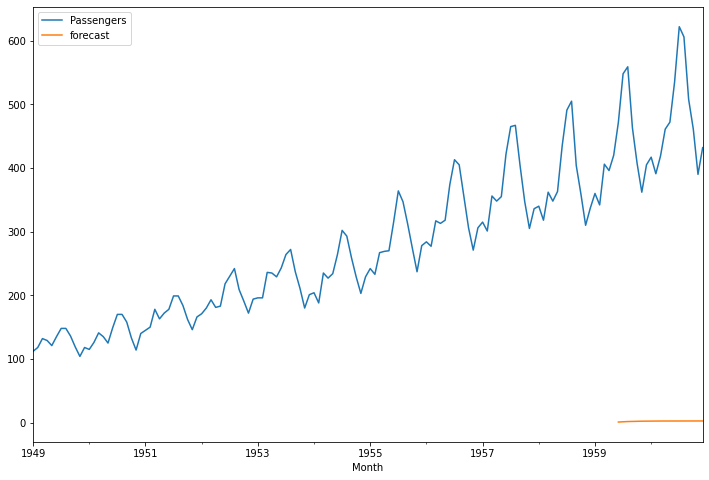

In [38]:
df['forecast']=model_arima_fit.predict(start=125,end=144,dynamic=True)
df[['Passengers','forecast']].plot(figsize=(12,8))

In [35]:
model_sarima=sm.tsa.statespace.SARIMAX(df['Passengers'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model_sarima.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


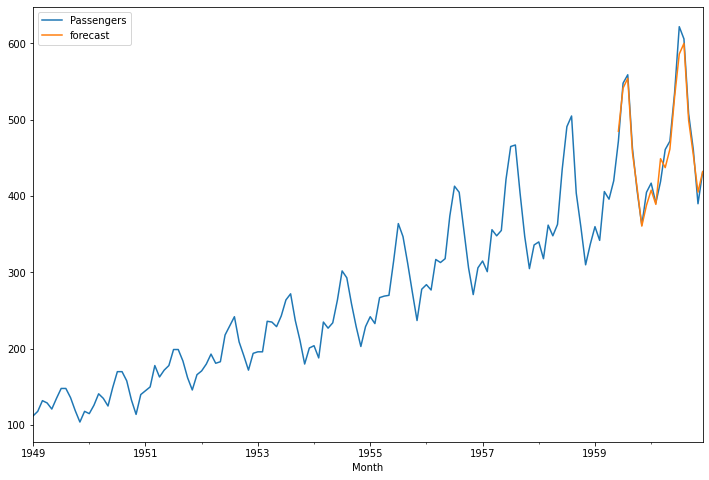

In [39]:
df['forecast']=results.predict(start=125,end=144,dynamic=True)
df[['Passengers','forecast']].plot(figsize=(12,8))

In [40]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,60)]

In [41]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [42]:
future_df=pd.concat([df,future_datest_df])

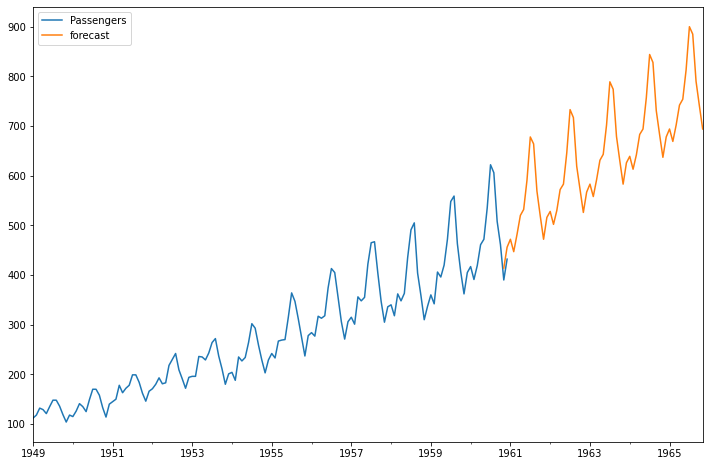

In [46]:
future_df['forecast'] = round(results.predict(start = 142, end = 204, dynamic= True),0)  
future_df[['Passengers', 'forecast']].plot(figsize=(12, 8)) 

In [47]:
future_df[['Passengers', 'forecast']]

,Passengers,forecast
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1965-07-01,NaN,900.0
1965-08-01,NaN,885.0
1965-09-01,NaN,790.0
1965-10-01,NaN,741.0
